In [1]:
# !pip install -r requirements.txt

In [2]:
import random as rn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.layers import Conv1D, LSTM, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import F1Score
from keras.regularizers import l2, l1

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as anndata
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import keras
import tensorflow as tf

Using TensorFlow backend


In [3]:
# set seed for reproducibility
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [4]:
# load data
adata = sc.read_h5ad('Group_7.h5ad')
adata

AnnData object with n_obs × n_vars = 34957 × 32738
    obs: 'cell-types'
    var: 'gene_ids'

In [5]:
# map cell types to a generic cell type mapping
cell_type_mapping = {
    'CD8+/CD45RA+ Naive Cytotoxic': 'T cell',
    'CD14+ Monocyte': 'Monocyte',
    'CD56+ NK': 'NK cell',
    'CD19+ B': 'B cell',
}
adata.obs['cell-types'] = adata.obs['cell-types'].map(cell_type_mapping)

In [6]:
# calculate QC metrics
# Identify mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Identify ribosomal genes (replace 'RPS' and 'RPL' with the actual prefixes used in your dataset)
adata.var['rb'] = adata.var_names.str.startswith(('RPS', 'RPL'))

# Calculate QC metrics for both mitochondrial and ribosomal genes
sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt', 'rb'], percent_top=None, log1p=False, inplace=True)

The number of outlier cells is:  4040


<ipython-input-7-92bc90a399e2>:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(adata.obs.n_genes_by_counts)


Number of cells after filtering cells:  30874


<ipython-input-7-92bc90a399e2>:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(adata_filtered.obs.n_genes_by_counts)
c:\Users\Amos Choo\Desktop\binf7000-a3\env\Lib\site-packages\scanpy\preprocessing\_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
c:\Users\Amos Choo\Desktop\binf7000-a3\env\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

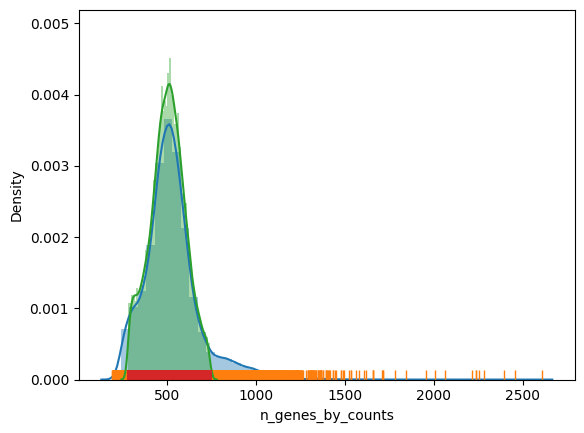

In [7]:
# preprocess, calculate and filter genes, normalize and scale data, reduce dimensionality
# total genes detected in each cell
total_genes_per_cells = adata.obs['n_genes_by_counts']

median_genes = np.median(total_genes_per_cells)

# Calculate MAD
mad_genes = np.median(np.abs(total_genes_per_cells - median_genes))

# Define lower and upper bounds
lower_bound = median_genes - 3 * mad_genes
upper_bound = median_genes + 3 * mad_genes

# Identify outlier cells
outlier_cells = np.sum((total_genes_per_cells < lower_bound)
                       | (total_genes_per_cells > upper_bound))

print("The number of outlier cells is: ", outlier_cells)
# Before filtering cells
sbn.distplot(adata.obs.n_genes_by_counts)
sbn.rugplot(adata.obs.n_genes_by_counts)
# After filtering cells
adata_filtered = adata[adata.obs.n_genes_by_counts > lower_bound, :]
adata_filtered = adata_filtered[adata_filtered.obs.n_genes_by_counts < upper_bound, :]
print('Number of cells after filtering cells: ', adata_filtered.shape[0])

# Check the effect of data preprocessing, notice the change to the normal distribution
sbn.distplot(adata_filtered.obs.n_genes_by_counts)
sbn.rugplot(adata_filtered.obs.n_genes_by_counts)
sc.pp.filter_genes(adata_filtered, min_cells=3)
sc.pp.normalize_total(adata_filtered, target_sum=None, inplace=True)
sc.pp.log1p(adata_filtered)
sc.pp.highly_variable_genes(
    adata_filtered, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata_filtered)
sc.tl.pca(adata_filtered, svd_solver='arpack')
sc.pp.neighbors(adata_filtered, n_neighbors=15, n_pcs=40)
# Embedding the neighborhood graph
sc.tl.umap(adata_filtered)

In [8]:
X = adata_filtered.obsm["X_umap"]  # features (PCA components)
y = adata_filtered.obs['cell-types']  # labels (cell types)

In [9]:
# label encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.values.reshape(-1, 1))
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.3, random_state=42)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
# CNN model


def build_model(hp):
    # Define the model
    model = Sequential()
    hp_neurons = hp.Int('neurons', min_value=2, max_value=12, step=1)
    model.add(Conv1D(filters=5, kernel_size=2,
              activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.25), bias_regularizer=l2(0.25), input_shape=(X_train.shape[1], 1), padding="same"))
    model.add(Conv1D(filters=5, kernel_size=2, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(
        0.25), bias_regularizer=l2(0.25), input_shape=(X_train.shape[1], 1), padding="same"))
    model.add(MaxPooling1D(pool_size=1))  # Added MaxPooling layer
    model.add(BatchNormalization())  # Added batch normalization layer
    model.add(Flatten())
    model.add(Dropout(0.1))  # Added dropout layer

    # Assuming 'y' is categorical
    model.add(Dense(hp_neurons, activation='relu',
              kernel_regularizer=l2(0.25), bias_regularizer=l2(0.25)))
    # Assuming 'y' is categorical
    model.add(Dense(hp_neurons//2, activation='relu',
              kernel_regularizer=l2(0.25), bias_regularizer=l2(0.25)))
    model.add(BatchNormalization())  # Added batch normalization layer
    model.add(Dropout(0.1))  # Added dropout layer
    model.add(Dense(y.nunique(), activation='softmax',
              kernel_regularizer=l2(0.25), bias_regularizer=l2(0.25)))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(
        learning_rate=0.001), loss='categorical_crossentropy', metrics=F1Score(average='macro'))

    return model

In [11]:
# uncomment to perform hyperparameter tuning


# hyperparameter search and k fold cross validation with no trial 3
tuner = kt.BayesianOptimization(
    build_model, objective='loss', max_trials=3, seed=42)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from .\untitled_project\tuner0.json


In [12]:
# uncomment for hyperparameter search and k fold cross validation with no trial 3

# model = tuner.hypermodel.build(best_hps)
# history = model.fit(X_train, y_train, epochs=50, batch_size=16,
#                     validation_split=0.2, callbacks=stop_early)

# val_acc_per_epoch = history.history['val_loss']
# best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))
best_epoch = 12

In [13]:
# uncomment them if you run hyperparameter search and k fold cross validation with no trial 3

# Plot training & validation accuracy values
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['f1_score'])
# plt.plot(history.history['val_f1_score'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

# plt.tight_layout()
# plt.show()

In [14]:
# Now retrain the model with the best epochs and params
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, batch_size=16)

Epoch 1/12
1351/1351 [==============================] - 18s 10ms/step - loss: 2.7399 - f1_score: 0.6109
Epoch 2/12
1351/1351 [==============================] - 15s 11ms/step - loss: 0.6345 - f1_score: 0.6756
Epoch 3/12
1351/1351 [==============================] - 13s 10ms/step - loss: 0.4768 - f1_score: 0.8339
Epoch 4/12
1351/1351 [==============================] - 10s 8ms/step - loss: 0.3611 - f1_score: 0.9742
Epoch 5/12
1351/1351 [==============================] - 9s 6ms/step - loss: 0.3006 - f1_score: 0.9827
Epoch 6/12
1351/1351 [==============================] - 11s 8ms/step - loss: 0.2639 - f1_score: 0.9841
Epoch 7/12
1351/1351 [==============================] - 15s 11ms/step - loss: 0.2406 - f1_score: 0.9831
Epoch 8/12
1351/1351 [==============================] - 13s 10ms/step - loss: 0.2166 - f1_score: 0.9839
Epoch 9/12
1351/1351 [==============================] - 13s 9ms/step - loss: 0.2000 - f1_score: 0.9837
Epoch 10/12
1351/1351 [==============================] - 13s 10ms/ste

290/290 [==============================] - 2s 5ms/step
Accuracy: 0.997948828673216
F1 Score: 0.997280057374031


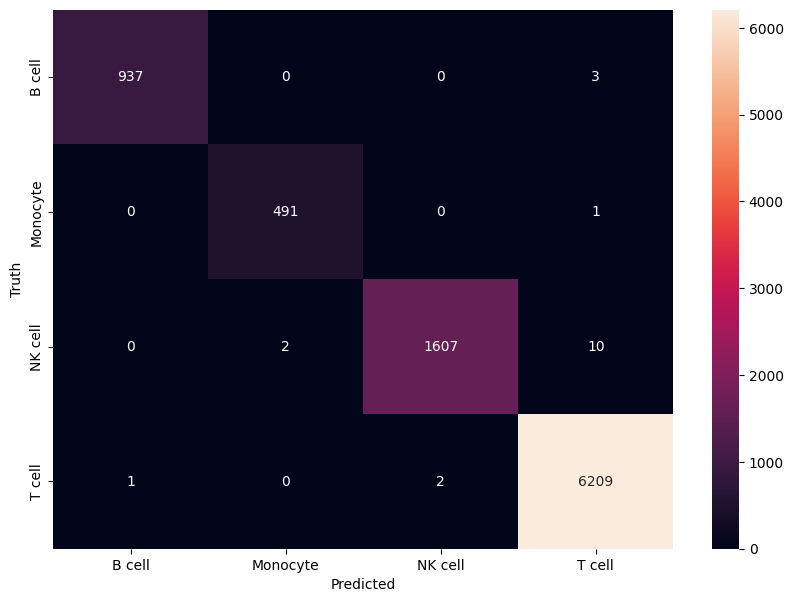

In [15]:
# Make predictions on the test set
y_pred = hypermodel.predict(X_test)
# Convert one-hot encoded test label to label encoded
y_test_label = np.argmax(y_test, axis=1)

# Convert one-hot encoded predictions to label encoded
y_pred_label = np.argmax(y_pred, axis=1)

# Calculate Accuracy
accuracy = accuracy_score(y_test_label, y_pred_label)
print(f'Accuracy: {accuracy}')

# Calculate F1 Score
f1 = f1_score(y_test_label, y_pred_label, average='macro')
print(f'F1 Score: {f1}')

classes = [label.split('_')[1] for label in encoder.get_feature_names_out()]

# Generate confusion matrix
cm = confusion_matrix(y_test_label, y_pred_label)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sbn.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

In [16]:
# Now test on unseen data
test_adata = sc.read_h5ad('Test_dataset.h5ad')

The number of outlier cells is:  5639


<ipython-input-17-99815fe36724>:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(test_adata.obs.n_genes_by_counts)


Number of cells after filtering cells:  40137


<ipython-input-17-99815fe36724>:38: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sbn.distplot(test_adata_filtered.obs.n_genes_by_counts)
c:\Users\Amos Choo\Desktop\binf7000-a3\env\Lib\site-packages\scanpy\preprocessing\_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


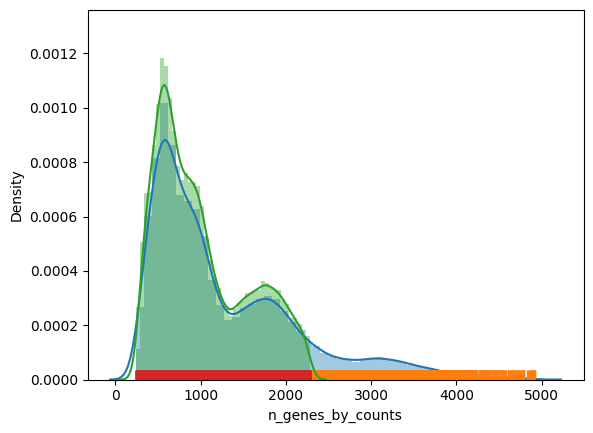

In [17]:
# Preprocess unseen data and filter genes
test_adata.var['mt'] = test_adata.var_names.str.startswith('MT-')

# Identify ribosomal genes (replace 'RPS' and 'RPL' with the actual prefixes used in your dataset)
test_adata.var['rb'] = test_adata.var_names.str.startswith(('RPS', 'RPL'))

# Calculate QC metrics for both mitochondrial and ribosomal genes
sc.pp.calculate_qc_metrics(
    test_adata, qc_vars=['mt', 'rb'], percent_top=None, log1p=False, inplace=True)
total_genes_per_cells = test_adata.obs['n_genes_by_counts']

median_genes = np.median(total_genes_per_cells)

# Calculate MAD
mad_genes = np.median(np.abs(total_genes_per_cells - median_genes))

# Define lower and upper bounds
lower_bound = median_genes - 3 * mad_genes
upper_bound = median_genes + 3 * mad_genes

# Identify outlier cells
outlier_cells = np.sum((total_genes_per_cells < lower_bound)
                       | (total_genes_per_cells > upper_bound))

print("The number of outlier cells is: ", outlier_cells)

# Before filtering cells
sbn.distplot(test_adata.obs.n_genes_by_counts)
sbn.rugplot(test_adata.obs.n_genes_by_counts)
# After filtering cells
test_adata_filtered = test_adata[test_adata.obs.n_genes_by_counts > lower_bound, :]
test_adata_filtered = test_adata_filtered[test_adata_filtered.obs.n_genes_by_counts < upper_bound, :]
print('Number of cells after filtering cells: ', test_adata_filtered.shape[0])

# Check the effect of data preprocessing, notice the change to the normal distribution
sbn.distplot(test_adata_filtered.obs.n_genes_by_counts)
sbn.rugplot(test_adata_filtered.obs.n_genes_by_counts)

sc.pp.filter_genes(test_adata_filtered, min_cells=3)

In [18]:
# Map to a general cell type
cell_types_to_filter = ['NK cell', 'B cell', 'CD8+ T cell', 'CD14+ Monocyte',
                        'CD4+ T cell', 'CD16+ Monocyte', 'Plasmablast', 'Other T']
mask = test_adata_filtered.obs['cell-types'].isin(cell_types_to_filter)
test_adata_filtered = test_adata_filtered[mask]

cell_type_mapping = {
    'CD8+ T cell': 'T cell',
    'CD4+ T cell': 'T cell',
    'Other T': 'T cell',
    'CD14+ Monocyte': 'Monocyte',
    'CD16+ Monocyte': 'Monocyte',
    'NK cell': 'NK cell',
    'B cell': 'B cell',
    'Plasmablast': 'B cell'
}

test_adata_filtered.obs['cell-types'] = test_adata_filtered.obs['cell-types'].map(
    cell_type_mapping)

<ipython-input-18-85a527abb61b>:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_adata_filtered.obs['cell-types'] = test_adata_filtered.obs['cell-types'].map(


In [19]:
# Transform data
X_unseen = test_adata_filtered.obsm["X_umap"]  # features (PCA components)
y_unseen = test_adata_filtered.obs['cell-types']  # labels (cell types)
y_onehot_unseen = encoder.transform(y_unseen.values.reshape(-1, 1))
# Reshape the data to be compatible with a 1D CNN
X_unseen = X_unseen.reshape((X_unseen.shape[0], X_unseen.shape[1], 1))

In [20]:
# Predict unseen data
y_unseen_pred = hypermodel.predict(X_unseen)

# Convert one-hot encoded test label to label encoded
y_unseen_label = np.argmax(y_onehot_unseen, axis=1)
original_labels = encoder.inverse_transform(y_onehot_unseen)
original_labels_pred = encoder.inverse_transform(y_unseen_pred)
print(original_labels)

# Convert one-hot encoded predictions to label encoded
y_unseen_pred_label = np.argmax(y_unseen_pred, axis=1)

# Calculate Accuracy
accuracy = accuracy_score(original_labels, original_labels_pred)
print(f'Accuracy: {accuracy}')

# Calculate F1 Score
f1 = f1_score(y_unseen_label, y_unseen_pred_label, average='macro')
print(f'F1 Score: {f1}')

1230/1230 [==============================] - 7s 5ms/step
[['T cell']
 ['T cell']
 ['Monocyte']
 ...
 ['T cell']
 ['T cell']
 ['T cell']]
Accuracy: 0.6528226113921155
F1 Score: 0.3818781116117451


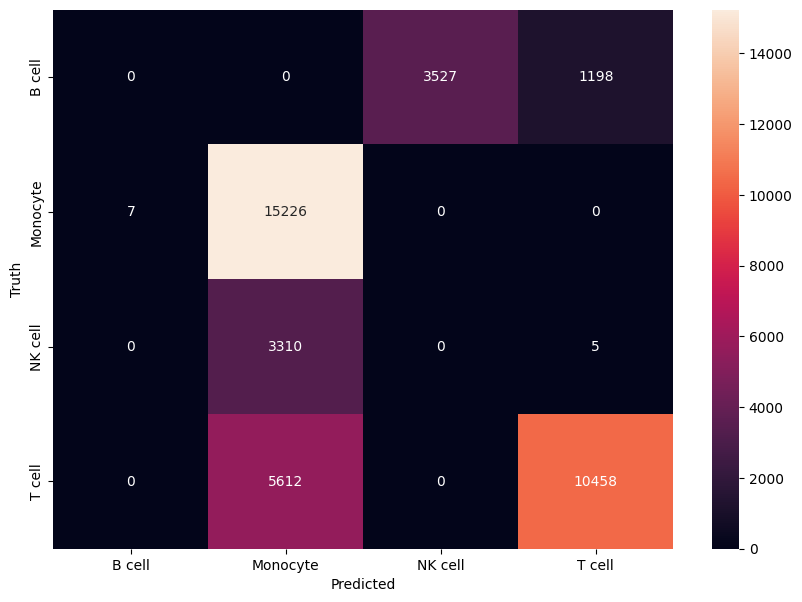

In [21]:
cm = confusion_matrix(original_labels, original_labels_pred,)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sbn.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

In [22]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 5)              15        
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 5)              15        
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 5)              55        
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 5)              0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 2, 5)              20        
 Normalization)                                                  
                                                        